In [29]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
pd.options.display.max_columns = None


In [30]:
libs = ['SRR1197125','SRR1197126','SRR1197127','SRR1197128']
path_annotation = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.42.gff3'
path_libs = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/sun_deg/%s'
path_transcripts = '/home/juan/Desktop/juan/bio/mirna_mite/data/fixed.cdna.all.fa'
path_transcripts_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/targets.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/transcripts_mites.csv'
path_blast_res_filtered = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/transcripts_mites.filtered.csv'
path_mirna_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv'
path_res_final = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/res_deg.csv'
path_ann = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.42.gff3'
path_psrna = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/psRNATargetJob-1567169569267499.txt'

In [31]:
dfs = []
for lib in libs:
    path_lib = path_libs % lib
    df = pd.read_csv(path_lib, sep='\t',comment='#')
    df['lib'] = lib
    dfs.append(df)


In [32]:
df = pd.concat(dfs)
print(len(df.index))

15313


In [33]:
df.drop_duplicates(['SiteID','Query','lib'], inplace=True)
print(len(df.index))

15313


In [34]:
df = df.reset_index(drop=True)


In [35]:
df = df[df.DegradomeCategory <= 3]
print(len(df.index))

6456


In [36]:
df_psrna = pd.read_csv(path_psrna, sep='\t', comment='#')
len(df_psrna.index)

41106

In [37]:
df_psrna.head(2)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6D02G238900.1,0.0,-1.0,1,21,577,597,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6D:339389350:339390413:1...,1
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6A02G257600.1,0.0,-1.0,1,21,559,579,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6A:479833651:479834702:1...,1


In [38]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,TraesCS1A02G000300.1:66,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000300.1,54,75,66,-43.6,-28.4,0.651376,9.0,"1-2,75-74;5-11,71-65;13-14,63-62;16-22,60-54","3-4,73-72[SIL];12-12,64-64[SIL];15-15,61-61[SIL]",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.953171,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125
1,TraesCS1A02G000400.1:1381,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000400.1,1369,1390,1381,-43.6,-28.4,0.651376,9.0,"1-2,1390-1389;5-11,1386-1380;13-14,1378-1377;1...","3-4,1388-1387[SIL];12-12,1379-1379[SIL];15-15,...",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.954807,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125


In [51]:
df_res_1 = pd.merge(df_psrna, df, left_on=['miRNA_Acc.','Target_Acc.','Target_start'], right_on=['Query','Transcript','TStart'])
print(len(df_res_1.index))
df_res_1.head(2)

616


,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,0.0,-1.0,1,21,204,224,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937802:22943978:-1 ...,1,TraesCS7A02G049100.2:215,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,204,224,215,-37.4,-35.4,0.946524,2.0,"1-19,224-206","20-21,205-204[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.023945,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197126
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,0.0,-1.0,1,21,438,458,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937762:22940558:-1 ...,1,TraesCS7A02G049100.1:449,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,438,458,449,-37.4,-35.4,0.946524,2.0,"1-19,458-440","20-21,439-438[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.029641,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127


In [52]:
df_res_2 = pd.merge(df_psrna, df, left_on=['miRNA_Acc.','Target_Acc.','Target_end'], right_on=['Query','Transcript','TStop'])
print(len(df_res_2.index))
df_res_2.head(2)

646


,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,0.0,-1.0,1,21,204,224,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937802:22943978:-1 ...,1,TraesCS7A02G049100.2:215,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,204,224,215,-37.4,-35.4,0.946524,2.0,"1-19,224-206","20-21,205-204[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.023945,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197126
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,0.0,-1.0,1,21,438,458,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937762:22940558:-1 ...,1,TraesCS7A02G049100.1:449,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,438,458,449,-37.4,-35.4,0.946524,2.0,"1-19,458-440","20-21,439-438[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.029641,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127


In [53]:
df_res = pd.concat([df_res_1, df_res_2])
print(len(df_res.index))
df_res = df_res.drop_duplicates()
print(len(df_res.index))

1262
665


In [62]:
df_res.head(10)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,0.0,-1.0,1,21,204,224,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937802:22943978:-1 ...,1,TraesCS7A02G049100.2:215,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,204,224,215,-37.4,-35.4,0.946524,2.0,"1-19,224-206","20-21,205-204[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.023945,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197126
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,0.0,-1.0,1,21,438,458,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937762:22940558:-1 ...,1,TraesCS7A02G049100.1:449,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,438,458,449,-37.4,-35.4,0.946524,2.0,"1-19,458-440","20-21,439-438[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.029641,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127
2,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS2A02G435100.1,0.0,-1.0,1,21,723,743,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:2A:687048698:687052485:1...,1,TraesCS2A02G435100.1:734,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS2A02G435100.1,723,743,734,-37.4,-35.4,0.946524,2.0,"1-19,743-725","20-21,724-723[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.002660,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125
3,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6D02G315700.1,0.0,-1.0,1,21,546,566,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6D:423814859:423816885:-...,1,TraesCS6D02G315700.1:557,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6D02G315700.1,546,566,557,-37.4,-35.4,0.946524,2.0,"1-19,566-548","20-21,547-546[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,1,0.000334,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127
4,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6A02G335900.1,0.0,-1.0,1,21,552,572,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6A:568515906:568517951:-...,1,TraesCS6A02G335900.1:563,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6A02G335900.1,552,572,563,-37.4,-35.4,0.946524,2.0,"1-19,572-554","20-21,553-552[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,0,0.000682,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127
5,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G366700.1,0.0,-1.0,1,21,550,570,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:6B:639532839:639534932:-...,1,TraesCS6B02G366700.1:561,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS6B02G366700.1,550,570,561,-37.4,-35.4,0.946524,2.0,"1-19,570-552","20-21,551-550[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,1,0.002056,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197126
6,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS4D02G020300.1,0.0,-1.0,1,21,537,557,UCCACAGGCUUUCUUGAACUG,:::::::::::::::::::,UCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:4D:8777205:8779937:1 gen...,1,TraesCS4D02G020300.1:548,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS4D02G020300.1,537,557,548,-37.4,-35.4,0.946524,2.0,"1-19,557-539","20-21,538-537[UP3]",..((((((((

In [57]:
df_res[['Target_Acc.','Target_start','Target_end','Transcript','TStart','TStop']].head(2)

,Target_Acc.,Target_start,Target_end,Transcript,TStart,TStop
0,TraesCS7A02G049100.2,204,224,TraesCS7A02G049100.2,204,224
1,TraesCS7A02G049100.1,438,458,TraesCS7A02G049100.1,438,458


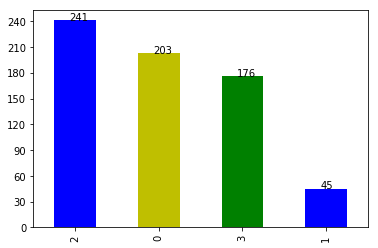

In [58]:
ax = df_res.DegradomeCategory.value_counts().plot('bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


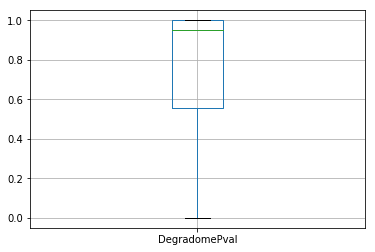

In [60]:
df.boxplot(column=['DegradomePval'])


In [63]:
print(len(df_res[df_res.DegradomePval < 0.05].index))

360


In [64]:
df_res.Transcript.nunique()

463

In [67]:
df_res['gene'] =  df_res.Transcript.str.split('.').str[0]

In [68]:
df_res.head(2)

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene
0,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,0.0,-1.0,1,21,204,224,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937802:22943978:-1 ...,1,TraesCS7A02G049100.2:215,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.2,204,224,215,-37.4,-35.4,0.946524,2.0,"1-19,224-206","20-21,205-204[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.023945,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197126,TraesCS7A02G049100
1,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,0.0,-1.0,1,21,438,458,UCCACAGGCUUUCUUGAACUG,: :::::::::::::::::::,CCGUUCAAGAAAGCCUGUGGA,Cleavage,cdna chromosome:IWGSC:7A:22937762:22940558:-1 ...,1,TraesCS7A02G049100.1:449,mrcv_all_Cluster_10948_2D_629186111_629186240,TraesCS7A02G049100.1,438,458,449,-37.4,-35.4,0.946524,2.0,"1-19,458-440","20-21,439-438[UP3]",..(((((((((((((((((((&)))))))))))))))))))..,CCGUUCAAGAAAGCCUGUGGA&UCCACAGGCUUUCUUGAACUG,2,0.029641,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127,TraesCS7A02G049100


In [69]:
df_res.gene.nunique()

417

In [70]:
df_res.Query.nunique()

145

In [71]:
transcripts = set()
for k,v in df_res.iterrows():
    transcript = v.Transcript
    transcripts.add(transcript)

In [72]:
fasta_seq = SeqIO.parse(path_transcripts, 'fasta')


In [73]:
lens = {}
buffer_seqs = []
for record in fasta_seq:
    if record.id in transcripts:
        buffer_seqs.append(record)
        clean_seq = ''.join(str(record.seq).splitlines())
        lens[record.id] = len(clean_seq)
SeqIO.write(buffer_seqs, path_transcripts_res, "fasta")
print(len(buffer_seqs))
print(path_transcripts_res)

463
/home/juan/Desktop/juan/bio/mirna_mite/data/res/targets.fa


In [41]:
path_blast_res

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/transcripts_mites.csv'

In [74]:
df_mites = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mites.columns = cols
df_mites = df_mites[df_mites.pident >= 85]
df_mites = df_mites[df_mites.qcovs >= 85]
print(len(df_mites.index))
df_mites.head(2)

1053


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3474,3394,7,1,90.123,2.290000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,2.290000e-25,81,80,3296,100,118


In [75]:
df_res['new_start'] = df_res[['TStart','TStop']].min(axis=1)
df_res['new_end'] = df_res[['TStart','TStop']].max(axis=1)
df_res['TStart'] = df_res['new_start']
df_res['TStop'] = df_res['new_end']
df_res = df_res.drop('new_start',axis=1).drop('new_end',axis=1)


In [76]:
df_mites['new_start'] = df_mites[['sstart','send']].min(axis=1)
df_mites['new_end'] = df_mites[['sstart','send']].max(axis=1)
df_mites['sstart'] = df_mites['new_start']
df_mites['send'] = df_mites['new_end']
df_mites = df_mites.drop('new_start',axis=1).drop('new_end',axis=1)


In [77]:
df_mites.head(4)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,2.290000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,2.290000e-25,81,80,3296,100,118
2,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,2.290000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,1.180000e-22,81,80,1296,100,108


In [78]:
df_mites = df_mites.drop_duplicates()


In [79]:
print(len(df_mites.index))
df_mites.head(8)

1021


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,2.290000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,2.290000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,1.180000e-22,81,80,1296,100,108
5,MITE_0,TraesCS4A02G349800.1,1,80,7444,7526,7,3,87.952,1.180000e-22,83,80,7721,100,108
7,MITE_0,TraesCS1D02G273500.1,1,80,916,996,9,1,87.654,1.180000e-22,81,80,1243,100,108
9,MITE_0,TraesCS4A02G193600.1,1,80,1145,1225,9,1,87.654,1.180000e-22,81,80,1259,100,108
11,MITE_0,TraesCS5A02G513500.1,2,80,982,1061,9,1,87.500,4.140000e-22,80,80,1132,100,106
12,MITE_0,TraesCS5A02G513500.1,1,79,982,1061,9,1,87.500,4.140000e-22,80,80,1132,100,106


In [80]:
#c_maxes = df_mites.groupby(['qseqid', 'sseqid']).score.transform(max)
#df_mites = df_mites.loc[df_mites.score == c_maxes]


In [81]:
df_mites.head(4)

,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,MITE_0,TraesCS1B02G479800.1,1,80,3394,3474,7,1,90.123,2.290000e-25,81,80,3785,100,118
1,MITE_0,TraesCS6A02G276700.1,1,80,3094,3174,7,1,90.123,2.290000e-25,81,80,3296,100,118
3,MITE_0,TraesCS3A02G274100.1,1,80,1077,1157,9,1,87.654,1.180000e-22,81,80,1296,100,108
5,MITE_0,TraesCS4A02G349800.1,1,80,7444,7526,7,3,87.952,1.180000e-22,83,80,7721,100,108


In [88]:
df_res['MITE'] = None

In [92]:
for k,v in df_res.iterrows():
    start = v.TStart
    end = v.TStop
    transcript = v.Transcript
    
    df_filter = df_mites[df_mites.qseqid.str.contains('DTT')]
    df_filter = df_filter[df_filter.sseqid==transcript]
    df_filter = df_filter[(df_filter.sstart <= start) & (df_filter.send >= end)]
    if len(df_filter.index) > 0:
        print(k, transcript,df_filter.loc[df_filter['score'].idxmax()].qseqid)
        df_res.at[k, 'MITE'] = df_filter.loc[df_filter['score'].idxmax()].qseqid
    else:
        df_filter = df_mites[df_mites.qseqid.str.contains('MITE_')]
        df_filter = df_filter[df_filter.sseqid==transcript]
        df_filter = df_filter[(df_filter.sstart <= start) & (df_filter.send >= end)]
        if len(df_filter.index) > 0:
            print(k,transcript,df_filter.loc[df_filter['score'].idxmax()].qseqid)
            df_res.at[k, 'MITE'] = df_filter.loc[df_filter['score'].idxmax()].qseqid
        

81 TraesCS1B02G460500.1 DTT_Bdis_BdisStowawayR_consensus-1
161 TraesCS5B02G218100.1 DTT_Hvul_Oleus_AF490468-1
162 TraesCS5B02G218100.1 DTT_Hvul_Oleus_AF490468-1
196 TraesCS5A02G513500.1 DTT_Taes_Athos_BJ282680-1
197 TraesCS1D02G273500.1 DTT_Taes_Athos_42j2-5
198 TraesCS3A02G274100.1 DTT_Tdur_Athos_103H9-1
199 TraesCS6B02G168300.1 DTT_Taes_Athos_42j2-4
200 TraesCS4B02G081200.1 DTT_Taes_Athos_BJ282680-1
201 TraesCS7A02G236200.4 DTT_Taes_Athos_BJ282680-1
202 TraesCS6A02G276700.1 DTT_Tmon_Athos_AF326781-1
203 TraesCSU02G068000.1 DTT_Tdur_Athos_103H9-1
204 TraesCS1B02G479800.1 DTT_Taes_Athos_BJ282680-1
205 TraesCS1D02G420700.1 DTT_Tdur_Athos_103H9-1
206 TraesCS7A02G002900.3 DTT_Taes_Athos_BJ282680-1
207 TraesCS4A02G193600.1 DTT_Taes_Athos_BJ282680-1
213 TraesCS5B02G444200.1 DTT_Tdur_Icarus_103H9-1
214 TraesCS2A02G281000.3 MITE_148
215 TraesCS2A02G281000.2 MITE_148
216 TraesCS2A02G281000.2 MITE_148
217 TraesCS7B02G184300.8 DTT_Hvul_Pan_M801L24-1
260 TraesCS2D02G578900.1 MITE_792
262 TraesCS7

In [93]:
df_res[df_res.Transcript == 'TraesCS5A02G456600.1']

,miRNA_Acc.,Target_Acc.,Expectation,UPE$,miRNA_start,miRNA_end,Target_start,Target_end,miRNA_aligned_fragment,alignment,Target_aligned_fragment,Inhibition,Target_Desc.,Multiplicity,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,gene,MITE
461,mrcv_all_Cluster_12767_3A_746087222_746087306,TraesCS5A02G456600.1,4.0,-1.0,1,21,1339,1359,UAAUAUGGAUUGGAGGGGGUA,:::.::::::. :::: ::::,UACUCCCUCCGUUCCAAAUUA,Translation,cdna chromosome:IWGSC:5A:636644175:636645689:1...,1,TraesCS5A02G456600.1:1350,mrcv_all_Cluster_12767_3A_746087222_746087306,TraesCS5A02G456600.1,1339,1359,1350,-37.0,-27.1,0.732432,5.5,"1-4,1359-1356;6-9,1354-1351;11-21,1349-1339","5-5,1355-1355[SIL];10-10,1350-1350[SIL]",(((((((((((.((((.((((&)))).)))).))))))))))),UACUCCCUCCGUUCCAAAUUA&UAAUAUGGAUUGGAGGGGGUA,2,0.897795,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197127,TraesCS5A02G456600,None
580,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS5A02G456600.1,4.5,-1.0,1,24,1345,1368,UGAGACGGGUAAUUUGGAACGGAG,::::::::::::::::.::::,CUCCGUUCCAAAUUACUCGUCGUG,Cleavage,cdna chromosome:IWGSC:5A:636644175:636645689:1...,1,TraesCS5A02G456600.1:1359,sun_mites_MITE_T_99232_2A_133702671_133702770,TraesCS5A02G456600.1,1345,1368,1359,-44.0,-37.0,0.840909,6.0,"4-24,1365-1345","1-3,1368-1366[UP5]",(((((((((((((((((((((...&...))))))))))))))))))))),CUCCGUUCCAAAUUACUCGUCGUG&UGAGACGGGUAAUUUGGAACGGAG,2,0.069269,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197128,TraesCS5A02G456600,MITE_792


In [94]:
df_mites.to_csv(path_blast_res_filtered,sep='\t', index=None)
path_blast_res_filtered

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/transcripts_mites.filtered.csv'

In [95]:
total = len(df_res.index)
w_mites = len(df_res[df_res.MITE.notnull()].index)
w_o_mites = len(df_res[df_res.MITE.isnull()].index)
print('Total', total)
print('W mites', w_mites)
print('WO mites', w_o_mites)
print(w_mites * 100 / total)

Total 665
W mites 56
WO mites 609
8.421052631578947


In [96]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,MITE
0,TraesCS1A02G000300.1:66,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000300.1,54.0,75.0,66.0,-43.6,-28.4,0.651376,9.0,"1-2,75-74;5-11,71-65;13-14,63-62;16-22,60-54","3-4,73-72[SIL];12-12,64-64[SIL];15-15,61-61[SIL]",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3.0,0.953171,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,NaN
1,TraesCS1A02G000400.1:1381,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000400.1,1369.0,1390.0,1381.0,-43.6,-28.4,0.651376,9.0,"1-2,1390-1389;5-11,1386-1380;13-14,1378-1377;1...","3-4,1388-1387[SIL];12-12,1379-1379[SIL];15-15,...",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3.0,0.954807,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,NaN


In [97]:
#add annotations

In [98]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann.index))

1957744


In [99]:
df_ann.head(1)

,seqname,source,feature,start,end,score,strand,frame,attribute
0,1A,International Wheat Genome Sequencing Consortium,chromosome,1,594102056,.,.,.,"ID=chromosome:1A;Alias=chr1A,LS992080.1"


In [100]:
df_ann['feature_len'] = abs(df_ann['start'] - df_ann['end'])


In [101]:
df_ann = df_ann[
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


216091


In [102]:
df_ann = df_ann.reset_index(drop=True)


In [103]:
df_ann['transcript'] = df_ann['attribute'].str.split('transcript:').str[1]
df_ann['transcript'] = df_ann['transcript'].str.split(';').str[0]

In [104]:
df_ann.head(5)

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
1,1A,IWGSC,three_prime_UTR,58474,58507,.,-,.,Parent=transcript:TraesCS1A02G000100.1,33,TraesCS1A02G000100.1
2,1A,IWGSC,five_prime_UTR,58769,58897,.,-,.,Parent=transcript:TraesCS1A02G000100.1,128,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
4,1A,IWGSC,three_prime_UTR,70557,70650,.,+,.,Parent=transcript:TraesCS1A02G000200.1,93,TraesCS1A02G000200.1


In [105]:
indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='five_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]


indexes = df_ann[(df_ann.strand=='+') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='last')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]

indexes = df_ann[(df_ann.strand=='-') & (df_ann.feature=='three_prime_UTR')].duplicated(['feature','transcript'],keep='first')
indexes = indexes[indexes == True].index
df_ann = df_ann[~df_ann.index.isin(indexes)]



In [106]:
print(len(df_ann.index))
df_ann.head(5)

180799


,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
0,1A,IWGSC,three_prime_UTR,40098,40731,.,-,.,Parent=transcript:TraesCS1A02G000100.1,633,TraesCS1A02G000100.1
3,1A,IWGSC,five_prime_UTR,70089,70338,.,-,.,Parent=transcript:TraesCS1A02G000100.1,249,TraesCS1A02G000100.1
5,1A,IWGSC,three_prime_UTR,88242,89245,.,+,.,Parent=transcript:TraesCS1A02G000200.1,1003,TraesCS1A02G000200.1
6,1A,IWGSC,five_prime_UTR,95906,96020,.,+,.,Parent=transcript:TraesCS1A02G000300.1,114,TraesCS1A02G000300.1
8,1A,IWGSC,five_prime_UTR,102794,104077,.,+,.,Parent=transcript:TraesCS1A02G000400.1,1283,TraesCS1A02G000400.1


In [66]:
df_res['annotation'] = ''

In [108]:
for k,v in df_res.iterrows():
    transcript_start = v.TStart
    transcript_stop = v.TStop
    transcript_slice = v.TSlice
    transcript_name = v.Transcript
    transcript_len = lens[transcript_name]
    other = df_ann[df_ann.transcript == transcript_name]
    for k2,v2 in other.iterrows():
        if v2.feature == 'five_prime_UTR' and v2.strand == '+' and transcript_slice <= v2.feature_len:
             df_res.loc[k, 'annotation'] = 'five_prime_UTR'
        if v2.feature == 'five_prime_UTR' and v2.strand == '-' and transcript_len - transcript_slice <= v2.feature_len:
             df_res.loc[k, 'annotation'] = 'five_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '+' and transcript_slice >= transcript_len - v2.feature_len:
             df_res.loc[k, 'annotation'] = 'three_prime_UTR'
        if v2.feature == 'three_prime_UTR' and v2.strand == '-' and transcript_slice <= v2.feature_len:
             df_res.loc[k, 'annotation'] = 'three_prime_UTR'


In [110]:
df_ann[df_ann.transcript=='TraesCS1A02G001400.1']

,seqname,source,feature,start,end,score,strand,frame,attribute,feature_len,transcript
20,1A,IWGSC,three_prime_UTR,294611,295669,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1058,TraesCS1A02G001400.1
22,1A,IWGSC,five_prime_UTR,304348,305428,.,-,.,Parent=transcript:TraesCS1A02G001400.1,1080,TraesCS1A02G001400.1


In [111]:
df_res['annotation'].fillna('exon', inplace=True)

In [112]:
df_res['annotation'].replace('', 'exon',inplace=True)

In [113]:
df_res[['SiteID','annotation']].head(10)

,SiteID,annotation
0,TraesCS7A02G049100.2:215,exon
1,TraesCS7A02G049100.1:449,exon
2,TraesCS2A02G435100.1:734,exon
3,TraesCS6D02G315700.1:557,exon
4,TraesCS6A02G335900.1:563,exon
5,TraesCS6B02G366700.1:561,exon
6,TraesCS4D02G020300.1:548,exon
7,TraesCS4D02G020300.1:548,exon
8,TraesCS4A02G291500.1:653,exon
9,TraesCS6A02G099407.1:875,exon


In [115]:
df_res['annotation'].value_counts()

exon               468
three_prime_UTR    158
five_prime_UTR      39
Name: annotation, dtype: int64

In [82]:
df_res[df_res.MITE.notnull()]['annotation'].value_counts()

exon               15
three_prime_UTR    10
five_prime_UTR      2
Name: annotation, dtype: int64

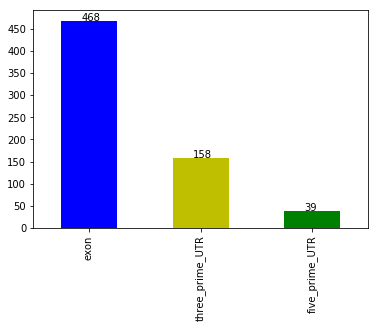

In [116]:
ax = df_res.annotation.value_counts().plot('bar',color=['b','y','g'])
x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
plt.savefig('../data/res/targets.png',transparent=True, bbox_inches='tight', pad_inches=0)

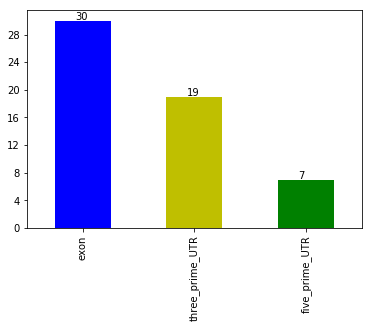

In [117]:
ax = df_res[df_res.MITE.notnull()].annotation.value_counts().plot('bar',color=['b','y','g'])

x_offset = -0.07
y_offset = 0.15
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
plt.savefig('../data/res/targets_mites.png',transparent=True, bbox_inches='tight', pad_inches=0)


In [122]:
df_res.to_csv(path_res_final, index=None)
path_res_final

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/res_deg.csv'

In [41]:
df.head(2)

,SiteID,Query,Transcript,TStart,TStop,TSlice,MFEperfect,MFEsite,MFEratio,AllenScore,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,MITE,annotation
0,TraesCS1A02G000300.1:66,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000300.1,54,75,66,-43.6,-28.4,0.651376,9.0,"1-2,75-74;5-11,71-65;13-14,63-62;16-22,60-54","3-4,73-72[SIL];12-12,64-64[SIL];15-15,61-61[SIL]",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.952678,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,None,five_prime_UTR
1,TraesCS1A02G000400.1:1381,sun_all_Cluster_118867_6B_214030433_214030626,TraesCS1A02G000400.1,1369,1390,1381,-43.6,-28.4,0.651376,9.0,"1-2,1390-1389;5-11,1386-1380;13-14,1378-1377;1...","3-4,1388-1387[SIL];12-12,1379-1379[SIL];15-15,...",(((((((.((.(((((((..((&))..))))))).)).))))))),GCAGAUCUUGGUGGUAGUAGCA&UGAAGCUGCCAGCAUGAUCUGC,3,0.950862,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,None,exon


In [42]:
df_mirna_res = pd.read_csv(path_mirna_res, sep='\t')
print(len(df_mirna_res.index))
df_mirna_res.head(2)

247


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
0,1A:309399489-309399664,mrcv_all_Cluster_872_1A_309399489_309399664,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN,intergenic
1,1A:419025472-419025570,mrcv_all_Cluster_1015_1A_419025472_419025570,99,384,3.014,20,1.000,+,CGAAUGUAUUUUUUAUGGCUUG,249,...,264,3,2,1A,419025472-419025570,419025472,419025570,NaN,NaN,intergenic


In [43]:
df_merge = pd.merge(df_mirna_res[df_mirna_res.MITE.notnull()],df[df.MITE.notnull()],left_on='Name', right_on='Query')

In [44]:
df_merge.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Paired,Unpaired,Structure,Sequence,DegradomeCategory,DegradomePval,Tplot_file_path,lib,MITE_y,annotation_y
0,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,"1-7,1956-1950;9-10,1949-1948;11-20,1946-1937","8-8,x-x[BULq];x-x,1947-1947[BULt];21-21,1936-1...",.((((((((((.((-(((((((&))))))).))-)))))))))).,UGUCUUACAUUAUG-GGACAGA&UCUGUUCACA-AAUGUAAGACG,4,0.51607,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,DTT_Taes_Athos_BJ319864-1,three_prime_UTR
1,1B:161992200-161992280,sun_all_Cluster_8835_1B_161992200_161992280,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,"1-7,2357-2351;9-10,2350-2349;11-21,2347-2337","8-8,x-x[BULq];x-x,2348-2348[BULt]",(((((((((((.((-(((((((&))))))).))-))))))))))),CGUCUUACAUUAUG-GGACGGA&UCUGUUCACA-AAUGUAAGACG,0,0.01299,/home/juan/Desktop/juan/bio/mirna_mite/data/re...,SRR1197125,MITE_502,three_prime_UTR


In [45]:
#extract MITE sequences
buffer_seqs = []
mites = list(df_merge.MITE_x.unique())
for record in fasta_seq:
    if record.id in mites:
        record.id += '_p'
        record.description = ''
        buffer_seqs.append(record)


In [46]:
path_mites_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mites_prod.fasta'
SeqIO.write(buffer_seqs, path_mites_prod_res, "fasta")
path_mites_prod_res

NameError: name 'path_mites_prod_res' is not defined

In [ ]:
df_mites = df[df.MITE != '']
df[df.MITE != ''][['SiteID','Query','Transcript','TStart','TStop','MITE','Sequence']].head()

In [ ]:
df_mirna_res = pd.read_csv(path_mirna_res, sep='\t')
df_mirna_res.rename(columns={'MITE':'MITE_prod'}, inplace=True)
print(len(df_mirna_res.index))
df_mirna_res.head(2)

In [ ]:
df_mirna_res_mites = df_mirna_res[df_mirna_res.MITE_prod.notnull()]
print(len(df_mirna_res_mites.index))


In [ ]:
df_mirna_res_mites['Name'] = df_mirna_res_mites.Name.str.split("|").str[0]

In [ ]:
df_mirna_res_mites_for_merge = df_mirna_res_mites[['Name','#Locus','MajorRNA','MITE_prod']]

In [ ]:
df_merge = pd.merge(df_mites,df_mirna_res_mites,left_on='Query', right_on='Name')

In [ ]:
df_new = df_merge[['SiteID','DegradomeCategory','Name','#Locus','MajorRNA','MITE','MITE_prod']]

In [ ]:
df_merge.head(2)

In [52]:
df_merge['equal_mite'] = 0
for k,v in df_merge.iterrows():
    prods = v.MITE_prod.split(',')
    target = v.MITE.split(',')
    prods = set(filter(None, prods))
    target = set(filter(None, target))
    inter = target.intersection(prods)
    if inter:
        print(v.SiteID, v.Name, inter)
        df_merge.at[k, 'equal_mite'] = 1

NameError: name 'df_merge' is not defined

In [ ]:
df_merge[df_merge.Name=='sun_all_Cluster_8835']

In [ ]:
total_ele = len(df_merge.index)
equal_mite = len(df_merge[df_merge.equal_mite==1].index)
print(equal_mite * 100 /total_ele)

In [ ]:
df_merge.to_csv(path_res_final, index=None)
path_res_final